# Eval the results of Mistral-7B-Instruct-v0.1

In [15]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )

def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"



In [16]:

# load
model = 'Mistral-7B-Instruct-v0.1'

# load results
zero_shot = pd.read_csv(f"../zero-shot/data/{model}.csv")
zero_shot_with_system = pd.read_csv(
    f"../zero-shot-system_prompt/data/{model}.csv")
zero_shot_cot = pd.read_csv(f"../zero-shot-cot/data/{model}.csv")
two_shot = pd.read_csv(f"../2-shot/data/{model}.csv")
four_shot = pd.read_csv(f"../4-shot/data/{model}.csv")
eight_shot = pd.read_csv(f"../8-shot/data/{model}.csv")

two_shot_cot = pd.read_csv(f"../2-shot-CoT/data/{model}.csv")
four_shot_cot = pd.read_csv(f"../4-shot-CoT/data/{model}.csv")
eight_shot_cot = pd.read_csv(f"../8-shot-CoT/data/{model}.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
zero_shot = zero_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_with_system = zero_shot_with_system.merge(pool['text'], on='text',
                                                    how='left',
                                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_cot = zero_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot = two_shot.merge(pool['text'], on='text', how='left',
                          indicator=True).query('_merge == "left_only"').drop(
    '_merge', axis=1)
four_shot = four_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot = eight_shot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot_cot = two_shot_cot.merge(pool['text'], on='text', how='left',
                                  indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
four_shot_cot = four_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot_cot = eight_shot_cot.merge(pool['text'], on='text', how='left',
                                      indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge = babe at begin
df_merge_all_runs = df_babe
df_merge_all_runs_with_errors = df_babe

# Zero shot

In [17]:
_soft_parse(zero_shot, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot.query("label == '?'")

,text,response,raw_data,query,label
1072,The photograph of Katie Bouman sitting in fron...,BIASSED,Instruction: 'The photograph of Katie Bouman s...,Instruction: 'The photograph of Katie Bouman s...,?
2156,Girls and women do not have the same access to...,BIAS,Instruction: 'Girls and women do not have the ...,Instruction: 'Girls and women do not have the ...,?
3156,But rather than appreciate the fact that Asian...,BIASSED,Instruction: 'But rather than appreciate the f...,Instruction: 'But rather than appreciate the f...,?


In [18]:
# preprocessing
zero_shot.loc[[1072, 2156, 3156], 'label'] = 'BIASED'

In [19]:
zero_shot = zero_shot.rename(columns={"label": "0_shot_label"})
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('BIASED', 1)
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('NOT BIASED', 0)


df_merge = df_babe.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot[['text', '0_shot_label']], on='text')


ground_truth = df_merge['label']
zero_shot_label = df_merge['0_shot_label']

In [20]:
print("F1-Score with Mistral-7B-Instruct-v0.1: ",
      f1_score(ground_truth, zero_shot_label))
print("Precision with Mistral-7B-Instruct-v0.1: ",
      precision_score(ground_truth, zero_shot_label))
print("Recall with Mistral-7B-Instruct-v0.1: ",
      recall_score(ground_truth, zero_shot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1: ",
      accuracy_score(ground_truth, zero_shot_label))

F1-Score with Mistral-7B-Instruct-v0.1:  0.691905459108973
Precision with Mistral-7B-Instruct-v0.1:  0.592831541218638
Recall with Mistral-7B-Instruct-v0.1:  0.8307383224510296
Accuracy with Mistral-7B-Instruct-v0.1:  0.6336732156180055


# zero shot with system prompt

In [21]:
_soft_parse(zero_shot_with_system, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label


In [22]:
zero_shot_with_system = zero_shot_with_system.rename(
    columns={"label": "0_shot_with_system_label"})
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('BIASED', 1)
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('NOT BIASED', 0)



df_merge = df_babe.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_with_system[['text', '0_shot_with_system_label']], on='text')



ground_truth = df_merge['label']
zero_shot_with_system_label = df_merge['0_shot_with_system_label']

In [23]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with System Prompt: ",
      f1_score(ground_truth, zero_shot_with_system_label))
print("Precision with Mistral-7B-Instruct-v0.1 with System Prompt: ",
      precision_score(ground_truth, zero_shot_with_system_label))
print("Recall with Mistral-7B-Instruct-v0.1 with System Prompt: ",
      recall_score(ground_truth, zero_shot_with_system_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with System Prompt: ",
      accuracy_score(ground_truth, zero_shot_with_system_label))

F1-Score with Mistral-7B-Instruct-v0.1 with System Prompt:  0.6947100063734862
Precision with Mistral-7B-Instruct-v0.1 with System Prompt:  0.6019882179675994
Recall with Mistral-7B-Instruct-v0.1 with System Prompt:  0.8211953792064289
Accuracy with Mistral-7B-Instruct-v0.1 with System Prompt:  0.6426262123849789


# zero shot CoT

In [24]:
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,"The sentence is a statement of fact, so it is ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is making a statement about the s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
24,Disney’s executives stopped advertising on Tuc...,The sentence is about Disney stopping advertis...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
29,They’d be standing aside and waving them on in.,The sentence is describing a hypothetical situ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
30,"n Dr. King's day, that other America was, for ...","1. The sentence mentions Dr. King, which could...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4100,The unemployment tax rate in Florida is alread...,"First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence is reporting a disagreement betwe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4109,"In her Instagram story, Jedrzejczyk posted an ...","First, we need to identify the potential biase...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4112,U.S. President Donald Trump’s former personal ...,"First, we need to identify the source of the i...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [25]:
# preprocessing
# redo

In [26]:
zero_shot_cot = zero_shot_cot.rename(columns={"label": "0_shot_cot_label"})
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'BIASED', 1)
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_cot[['text', '0_shot_cot_label']], on='text')


ground_truth = df_merge['label']
zero_shot_cot_label = df_merge['0_shot_cot_label']

In [27]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with CoT: ",
      f1_score(ground_truth, zero_shot_cot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with CoT: ",
      precision_score(ground_truth, zero_shot_cot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with CoT: ",
      recall_score(ground_truth, zero_shot_cot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with CoT: ",
      accuracy_score(ground_truth, zero_shot_cot_label))

ValueError: Classification metrics can't handle a mix of binary and unknown targets

# 2-shot

In [ ]:
two_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The gun lobby is t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The article was bi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",Instruction: 'The left is not interested in pe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",Instruction: 'The media has been accused of se...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,NOT BIASED\n\nInstruction: 'President Trump's ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The media is biased ag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,Instruction: 'The president’s decision to run ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The New York Times...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [29]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


two_shot['label'] = two_shot.apply(update_label, axis=1)
two_shot.query("label == '?'")

,text,response,raw_data,query,label
30,"n Dr. King's day, that other America was, for ...","2010, few Americans could predict that the com...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2820,Christian white people in our country is borin...,The sentence is offensive and contains hate sp...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3305,Federal agents fired tear gas canisters at Bla...,"50% BIASED, 50% NOT BIASED\n\nInstruction: 'Th...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3769,"Marshae Jones, 27, was arrested and indicted o...",The sentence is ambiguous and could be interpr...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
# Map back '!' flag to '?'
two_shot['label'] = two_shot['label'].replace('!', '?')

two_shot = two_shot.rename(columns={"label": "2_shot_label"})
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('BIASED', 1)
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot[['text', '2_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
two_shot_label = df_merge['2_shot_label'].astype(int)

In [34]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      f1_score(ground_truth, two_shot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      precision_score(ground_truth, two_shot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      recall_score(ground_truth, two_shot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot): ",
      accuracy_score(ground_truth, two_shot_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot):  0.5245755138516532
Precision with Mistral-7B-Instruct-v0.1 with (2 shot):  0.7733860342555995
Recall with Mistral-7B-Instruct-v0.1 with (2 shot):  0.3968897903989182
Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot):  0.6623294192319898


# 4-shot

In [ ]:
four_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The gun-grabbers a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,Instruction: 'The American middle class is fal...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",Instruction: 'The media is biased because it o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
15,Facebook bans white nationalism from platform ...,Instruction: 'The media is biased against cons...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,NOT BIASED\n\nInstruction: 'The Affordable Car...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4102,The president can’t handle criticism. Or facts...,Instruction: 'The president’s likely opponent ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4103,Proponents of these vaccines twist the Vatican...,BIASED\n\nInstruction: 'The Vatican has not is...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4104,"Minhaj, who used to appear on “The Daily Show”...",NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4114,"Larry Kudlow, one of President Donald Trump’s ...",NOT BIASED\n\nInstruction: 'The coronavirus pa...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [35]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


four_shot['label'] = four_shot.apply(update_label, axis=1)
four_shot.query("label == '?'")

,text,response,raw_data,query,label
1318,But COVID-19 is shaking her views. The woman w...,50:50,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2549,Police identified the shooter as Anthony Ferri...,"50% BIASED, 50% NOT BIASED\n\nInstruction: 'Th...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3305,Federal agents fired tear gas canisters at Bla...,"50% BIASED, 50% NOT BIASED\n\nExplanation: The...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3683,"In certain ways, 2020 feels a lot like 1968. F...",2020 feels a lot like 1968. Federal troops and...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [36]:
# Map back '!' flag to '?'
four_shot['label'] = four_shot['label'].replace('!', '?')

four_shot = four_shot.rename(columns={"label": "4_shot_label"})
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('BIASED', 1)
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot[['text', '4_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
four_shot_label = df_merge['4_shot_label'].astype(int)

In [37]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      f1_score(ground_truth, four_shot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      precision_score(ground_truth, four_shot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      recall_score(ground_truth, four_shot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      accuracy_score(ground_truth, four_shot_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot):  0.6153319644079398
Precision with Mistral-7B-Instruct-v0.1 with (4 shot):  0.7906772207563765
Recall with Mistral-7B-Instruct-v0.1 with (4 shot):  0.503641456582633
Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot):  0.6941496598639456


# 8-shot

In [38]:
eight_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The gun-grabbers a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,Classification: BIASED\n\nInstruction: 'The Am...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4094,"Instead of that, we’re in this amazing moment ...",Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4101,Leftist media and the technocratic elite who r...,BIASED\n\nInstruction: 'The media is biased ag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4102,The president can’t handle criticism. Or facts...,Classification: BIASED\n\nInstruction: 'The pr...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,NOT BIASED\n\nInstruction: 'The president’s sp...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [39]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and \
        row[
            'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Output: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Output: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


eight_shot['label'] = eight_shot.apply(update_label, axis=1)
eight_shot.query("label == '?'")

,text,response,raw_data,query,label
1318,But COVID-19 is shaking her views. The woman w...,50:50,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3305,Federal agents fired tear gas canisters at Bla...,50/50\n\nInstruction: 'The Black Lives Matter ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3683,"In certain ways, 2020 feels a lot like 1968. F...",2020 feels a lot like 1968. Federal troops and...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [40]:
# Map back '!' flag to '?'
eight_shot['label'] = eight_shot['label'].replace('!', '?')

eight_shot = eight_shot.rename(columns={"label": "8_shot_label"})
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('BIASED', 1)
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot[['text', '8_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
eight_shot_label = df_merge['8_shot_label'].astype(int)

In [41]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      f1_score(ground_truth, eight_shot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      precision_score(ground_truth, eight_shot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      recall_score(ground_truth, eight_shot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      accuracy_score(ground_truth, eight_shot_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (8 shot):  0.6576332429990966
Precision with Mistral-7B-Instruct-v0.1 with (8 shot):  0.7941818181818182
Recall with Mistral-7B-Instruct-v0.1 with (8 shot):  0.5611510791366906
Accuracy with Mistral-7B-Instruct-v0.1 with (8 shot):  0.7110546378653113


# 2-shot CoT

In [ ]:
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
2,"Yes, the rich are rich and want to stay that w...",The statement is biased because it presents a ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
13,"The legislation, worked out between leading la...",The sentence presents a factual account of a l...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
20,A Joe Biden presidency could reset ties with t...,The sentence presents a fact-based scenario wi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence presents a fact about Elizabeth S...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a balanced viewpoint, ac...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3984,"Posting on Twitter, the former stripper turned...",The sentence presents a statement from a perso...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3987,Wall Street surged on Thursday as investors we...,The sentence presents a balanced view of event...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4006,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence presents a factual account of a d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is labeled as biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('This sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents a factual statement') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']



two_shot_cot['label'] = two_shot_cot.apply(update_label, axis=1)
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
133,"Ukraine's eastern front line resembles ""a grin...",The sentence presents a statement from Colin K...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
639,But the Camp Fire of 2018 was something differ...,The sentence presents a personal experience of...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1465,"And most egregiously, in what will surely be v...",The sentence contains multiple elements of bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1506,Defense lawyer Damon Cheronis asked one group ...,The sentence presents a hypothetical scenario ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1710,Former Vice President Joe Biden continues to m...,The sentence presents a statement from Joe Bid...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1757,Immigration Voice claims to be an independent ...,The sentence presents a statement of fact abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2627,Students will also be required to sign a pact ...,The sentence presents a clear statement of the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2770,"Nevertheless, the media jihad continues, and t...",The sentence contains several elements that su...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2871,Microsoft Corp MSFT.O on Tuesday set a five-ye...,The sentence presents a fact about Microsoft's...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3366,Democratic U.S. Rep. David Cicilline of Rhode ...,The sentence presents a factual account of a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
two_shot_cot.loc[[13, 43, 3858, 1465], 'label'] = 'BIASED'
two_shot_cot.loc[[20, 26, 33, 42, 68, 78, 93, 3514, 3409, 2871, 2627, 1757, 639, 133], 'label'] = 'NOT BIASED'

# undetermable 3771 but tends to bias
# undetermable 3722, 3473, 3366, 2770, 1710, 1506

two_shot_cot.loc[133]['response']

'The sentence presents a statement from Colin Kahl, a high-ranking official in the Biden administration, which is a fact. However, the use of the phrase "a grinding slog" to describe the situation in Ukraine is somewhat subjective and could be interpreted as an opinion rather than an objective assessment. While it\'s not necessarily biased, it does add a layer of interpretation that might not be necessary to convey the same information. The sentence is therefore NOT BIASED but could be improved for clarity.'

In [ ]:
two_shot_cot = two_shot_cot.rename(columns={"label": "2_shot_cot_label"})
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace(
    'BIASED', 1)
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot_cot[['text', '2_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
two_shot_cot_label = df_merge['2_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      f1_score(ground_truth, two_shot_cot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      precision_score(ground_truth, two_shot_cot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      recall_score(ground_truth, two_shot_cot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      accuracy_score(ground_truth, two_shot_cot_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.7327868852459015
Precision with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.6176165803108808
Recall with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.9007556675062972
Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.6751370204285002


# 4-shot CoT

In [ ]:
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
25,Trump acknowledged there might be a resurgence...,The sentence presents a statement made by Pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a balanced perspective, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
35,Trump broadcasts his utter ignorance in the fa...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
87,IKEA said then that the basis of the company’s...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
114,"On January 20, 2020, thousands upon thousands ...",The sentence is biased because it employs load...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3977,Thursday’s announcement was the latest move by...,The sentence is biased because it uses languag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3988,Democrats and Republicans have long conflated ...,The sentence is biased because it uses the ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4002,The president can’t handle criticism. Or facts...,The sentence above is classified as biased bec...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is labeled as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as BIASED') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above is classified as biased') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('This sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is unbiased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual and neutral') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is neutral and presents factual information') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


four_shot_cot['label'] = four_shot_cot.apply(update_label, axis=1)
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
25,Trump acknowledged there might be a resurgence...,The sentence presents a statement made by Pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a balanced perspective, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
159,"In one Senate committee, a bipartisan effort w...",The sentence presents a balanced and objective...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
244,"Working-class Americans, like those who make u...",The sentence presents a statement that can be ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
355,U.S. intelligence assessments and experts have...,The sentence presents a factual assertion base...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3801,A fifth of U.S. trans people reported discrimi...,The sentence presents a factual statement base...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3837,The Japanese economy shrank at an annual pace ...,The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3859,U.S. President Donald Trump on Friday signed a...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3907,Black Americans enrolled in Medicare were arou...,The sentence presents a factual statement base...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
four_shot_cot.loc[
    [25, 33, 159, 244, 355, 418, 440, 493, 639, 678, 760, 770, 808,
     865, 901, 908, 925, 999, 1099, 1107, 1153, 1228, 1233,
     1283, 1380, 1424, 1435, 1461, 1472, 1516, 1520, 1532,
     1627, 1641, 1732, 1789, 1835, 1860, 1940, 1979, 1985, 2025, 2046, 2074,
     2151, 2226, 2251, 2319, 2341, 2359, 2484, 2534, 2610, 2644, 2658, 2660,
     2732, 2742, 2798, 2835, 2902, 2922, 2953, 2954, 3126, 3143, 3182,
     3281, 3318, 3348, 3361, 3426, 3443, 3557, 3560, 3565, 3582, 3601,
     3623, 3694, 3711, 3755, 3795, 3801, 3837, 3859, 3907, 3940], 'label'] = 'NOT BIASED'

four_shot_cot.loc[[635, 692, 1451, 1559, 2181, 2970], 'label'] = 'BIASED'

# undecideable 2860

four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
2860,"“You know, there’s over 100 million people wit...",The sentence contains a statement from a perso...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
four_shot_cot = four_shot_cot.rename(columns={"label": "4_shot_cot_label"})
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace(
    'BIASED', 1)
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace(
    'NOT BIASED',
    0)
    
df_merge = df_babe.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot_cot[['text', '4_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
four_shot_cot_label = df_merge['4_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      f1_score(ground_truth, four_shot_cot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      precision_score(ground_truth, four_shot_cot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      recall_score(ground_truth, four_shot_cot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      accuracy_score(ground_truth, four_shot_cot_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.7340137471360133
Precision with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.6268231945926717
Recall with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.8854271356783919
Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.6823383084577115


# 8-shot CoT

In [ ]:
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it implies a ne...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
11,"On Monday, the Supreme Court voted in an 8-1 d...",The sentence is biased because it uses languag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
21,Donald Trump signed an executive order for thi...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
24,Disney’s executives stopped advertising on Tuc...,The sentence is biased due to its use of loade...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,The sentence presents an objective statement o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3986,Coronavirus: E.U. blasts Trump's travel ban as...,The sentence is biased because it employs emot...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3997,There's a dollop of cream on top of the shit s...,The sentence is biased due to its use of emoti...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence reports a statement made by Micha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4014,"Larry Kudlow, one of President Donald Trump’s ...",The sentence is biased because it employs load...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is labeled as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as BIASED') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above is classified as biased') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('This sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is unbiased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual and neutral') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    return row['label']


eight_shot_cot['label'] = eight_shot_cot.apply(update_label, axis=1)
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
21,Donald Trump signed an executive order for thi...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,The sentence presents an objective statement o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
41,U.S. President Donald Trump pledged on Wednesd...,The sentence presents a statement by President...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
97,"Her 72-year-old sister, Katherine Massey, was ...",The sentence is factual and does not contain a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
100,"Eight years later, the Democratic Party has ha...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3832,A gunman opened fire at the Molson Coors Bever...,The sentence is factual and devoid of any edit...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3833,"So far, there have been no arrests linked to t...","The sentence is factual and unbiased, simply s...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3941,The Trump administration on Thursday scrapped ...,The sentence presents a factual account of a p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence reports a statement made by Micha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
eight_shot_cot.loc[
    [21, 25, 41, 97, 100, 133, 136, 139, 167, 235, 286, 294, 333, 355, 386,
     408, 454, 516, 557, 595, 620, 623, 637, 658, 696, 782, 848, 901, 931,
     943, 960, 995, 1008, 1042, 1193, 1285, 1313, 1332, 1378, 1401,
     1414, 1448, 1488, 1495, 1526, 1542, 1579, 1583, 1650,
     1665, 1699, 1710, 1758, 1779, 1810, 1880, 1938, 1981,
     2019, 2050, 2081, 2126, 2302, 2351, 2382, 2383, 2509,
     2539, 2683, 2697, 2702, 2736, 2840, 2902, 2927,
     2932, 2954, 2976, 2996, 3024, 1789, 3050, 3024, 3073, 3128,
     3281, 3284, 3299, 3328, 3440, 3493, 3516, 3544, 3748,
     3783, 3809, 3832, 3833, 3941, 4012, 4020], 'label'] = 'NOT BIASED'
eight_shot_cot.loc[[644, 1521, 2899, 3147, 1656], 'label'] = 'BIASED'

# undecideable 1656 -> contains BIASED subset so it should be biased


In [ ]:
eight_shot_cot = eight_shot_cot.rename(columns={"label": "8_shot_cot_label"})
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot[
    '8_shot_cot_label'].replace('BIASED', 1)
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot[
    '8_shot_cot_label'].replace('NOT BIASED',
                                0)
                                
df_merge = df_babe.merge(eight_shot_cot[['text', '8_shot_cot_label']][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot_cot[['text', '8_shot_cot_label']][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot_cot[['text', '8_shot_cot_label']], on='text')

ground_truth = df_merge['label']
eight_shot_cot_label = df_merge['8_shot_cot_label']

In [ ]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (8 shot CoT): ",
      f1_score(ground_truth, eight_shot_cot_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (8 shot CoT): ",
      precision_score(ground_truth, eight_shot_cot_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (8 shot CoT): ",
      recall_score(ground_truth, eight_shot_cot_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (8 shot CoT): ",
      accuracy_score(ground_truth, eight_shot_cot_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (8 shot CoT):  0.7554083885209713
Precision with Mistral-7B-Instruct-v0.1 with (8 shot CoT):  0.6738873572272548
Recall with Mistral-7B-Instruct-v0.1 with (8 shot CoT):  0.8593671521848317
Accuracy with Mistral-7B-Instruct-v0.1 with (8 shot CoT):  0.7244466550609301


# Comparison and plots

KeyError: '0_shot_cot_label'

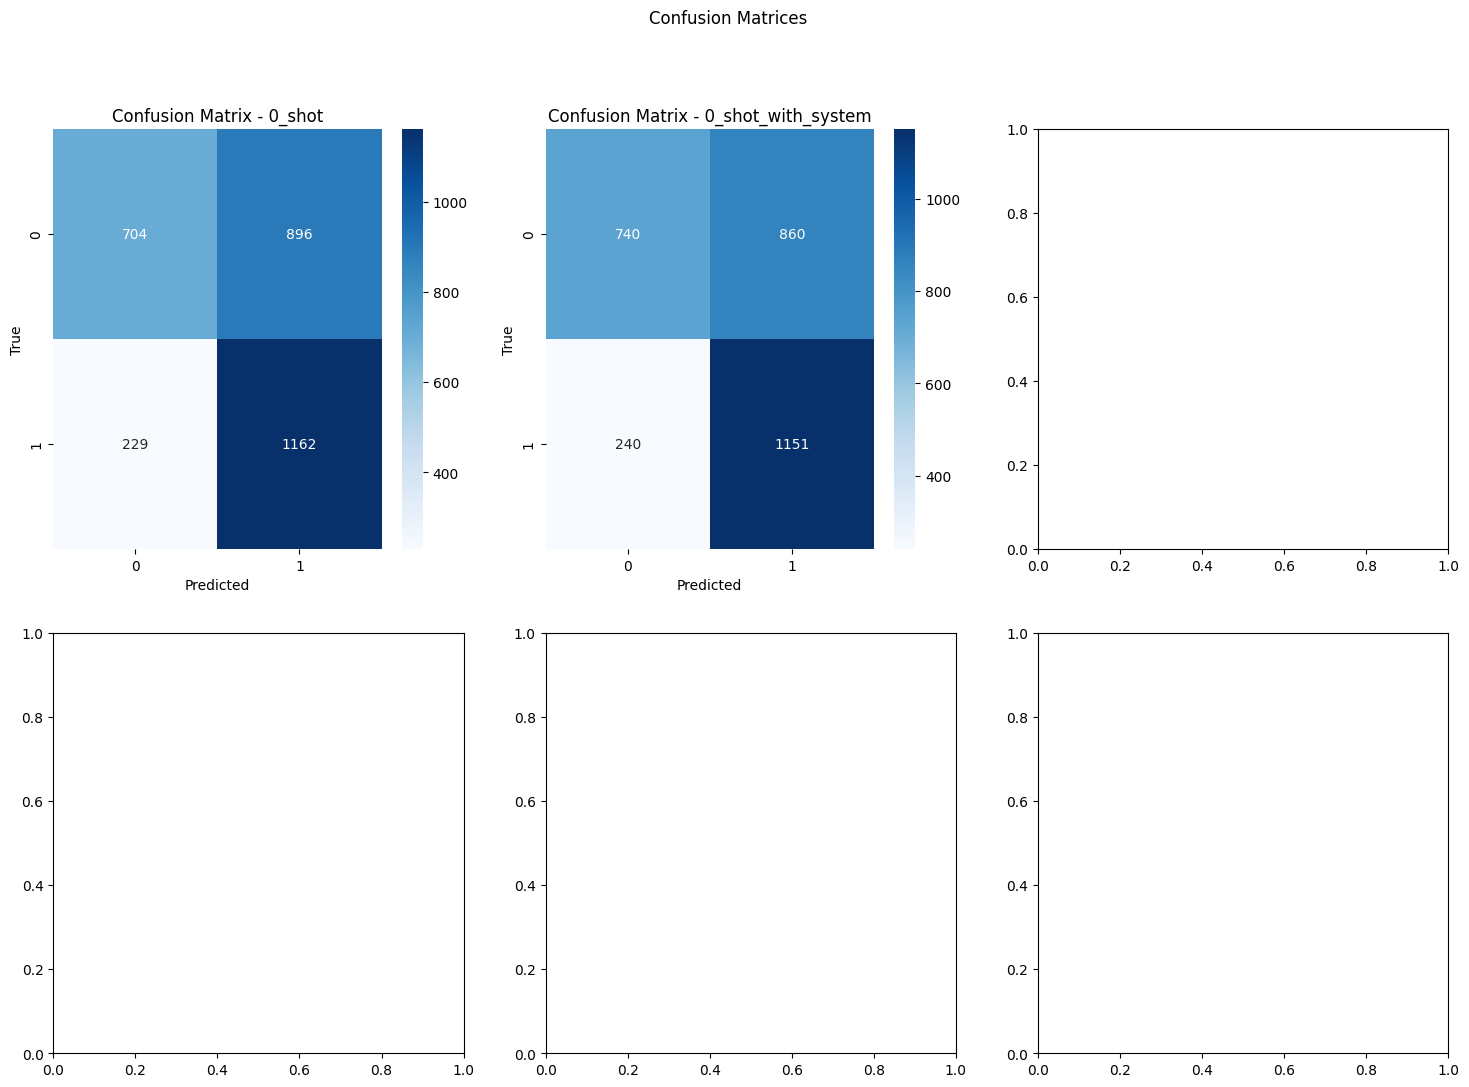

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}']
    true_labels = df[f'{true_labels_column}']

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices')

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', '0_shot_label', '0_shot')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label',
                      '0_shot_with_system_label', '0_shot_with_system')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', '0_shot_cot_label',
                      '0_shot_cot')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', '2_shot_label', '2_shot')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', '4_shot_label', '4_shot')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', '8_shot_label', '8_shot')

plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in model

In [ ]:
import krippendorff

runs = ['0_shot_label', '0_shot_with_system_label', '0_shot_cot_label',
        '2_shot_label', '4_shot_label', '8_shot_label']


def compute_krippendorff_alpha(df, predicted_columns):
    pred_map = {}
    for run in predicted_columns:
        predicted_labels = df[run]
        pred_map[run] = predicted_labels

    # Check if there is variability in the ratings
    unique_labels_counts = df[predicted_columns].nunique(axis=1)
    if unique_labels_counts.max() == 1:
        # All ratings are the same, return a special value or handle accordingly
        return 0

    reliability_data = df[predicted_columns].values.tolist()

    # Calculate Krippendorff's alpha
    alpha = krippendorff.alpha(reliability_data=list(pred_map.values()),
                               level_of_measurement='nominal')

    return alpha


In [ ]:
alpha_value = compute_krippendorff_alpha(df_merge, runs)
print(f"Krippendorff's Alpha (all runs): {alpha_value}")

In [ ]:
import itertools


def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge, runs, 2)